# Conditioning
---
## Cognition and conditioning
We have built up a tool set for constructing probabilistic generative models. These can represent knowledge about causal processes in the world: running one of these programs generates a particular outcome by sampling a “history” for that outcome. However, the power of a causal model lies in the flexible ways it can be used to reason about the world. In the last chapter we ran generative models forward to reason about outcomes from initial conditions. Generative models also enable reasoning in other ways. For instance, if we have a generative model in which X is the output of a process that depends on Y (say `X = coolFunction(Y)`) we may ask: “assuming I have observed a certain X, what must Y have been?” That is we can reason backward from outcomes to initial conditions. More generally, we can make hypothetical assumptions and reason about the generative history: “assuming something, how did the generative model run?” In this section we describe how a wide variety of such hypothetical inferences can be made from a single generative model by conditioning the model on an assumed or observed fact.

Much of cognition can be understood in terms of conditional inference. In its most basic form, causal attribution is conditional inference: given some observed effects, what were the likely causes? Predictions are conditional inferences in the opposite direction: given that I have observed some cause, what are its likely effects? These inferences can be described by conditioning a probabilistic program that expresses a causal model. The acquisition of that causal model, or learning, is also conditional inference at a higher level of abstraction: given our general knowledge of how causal relations operate in the world, and some observed events in which candidate causes and effects co-occur in various ways, what specific causal relations are likely to hold between these observed variables?

To see how the same concepts apply in a domain that is not usually thought of as causal, consider language. The core questions of interest in the study of natural language are all at heart conditional inference problems. Given beliefs about the structure of my language, and an observed sentence, what should I believe about the syntactic structure of that sentence? This is the parsing problem. The complementary problem of speech production is related: given the structure of my language (and beliefs about others’ beliefs about that), and a particular thought I want to express, how should I encode the thought? Finally, the acquisition problem: given some data from a particular language, and perhaps general knowledge about universals of grammar, what should we believe about that language’s structure? This problem is simultaneously the problem facing the linguist and the child trying to learn a language.

Parallel problems of conditional inference arise in visual perception, social cognition, and virtually every other domain of cognition. In visual perception, we observe an image or image sequence that is the result of rendering a three-dimensional physical scene onto our two-dimensional retinas. A probabilistic program can model both the physical processes at work in the world that produce natural scenes, and the imaging processes (the “graphics”) that generate images from scenes. Perception can then be seen as conditioning this program on some observed output image and inferring the scenes most likely to have given rise to it.

When interacting with other people, we observe their actions, which result from a planning process, and often want to guess their desires, beliefs, emotions, or future actions. Planning can be modeled as a program that takes as input an agent’s mental states (beliefs, desires, etc.) and produces action sequences—for a rational agent, these will be actions that are likely to produce the agent’s desired states reliably and efficiently. A rational agent can plan their actions by conditional inference to infer what steps would be most likely to achieve their desired state. Action understanding, or interpreting an agent’s observed behavior, can be expressed as conditioning a planning program (a “theory of mind”) on observed actions to infer the mental states that most likely gave rise to those actions, and to predict how the agent is likely to act in the future.

### Reasoning with inference
Suppose that we know some fixed fact, and we wish to consider hypotheses about how a generative model could have given rise to that fact. using if statments, latent variables and infernce function we can describe the conditional distributions 

Consider the following simple generative model:

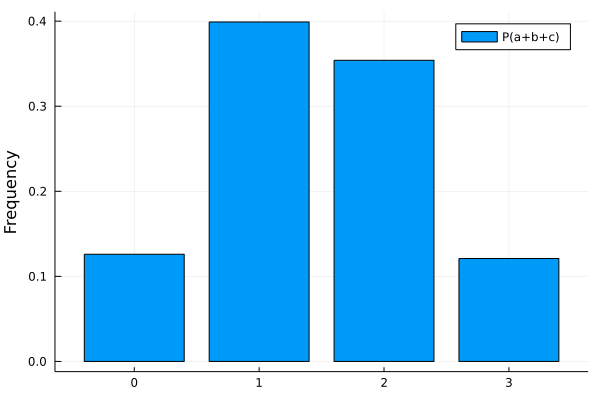

In [13]:
using Gen
include("auxilery.jl")
@gen function model()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    d=a+b+c
end
ys=[get_retval(simulate(model,())) for _ in 1:1000]
viz(ys, "P(a+b+c)")

The process described in `model` samples three numbers and adds them (recall Julia converts booleans to 0 or 1 when they enter arithmetic). The value of the final expression here is 0, 1, 2 or 3. A priori, each of the variables `A`, `B`, `C` has .5 probability of being `1` or `0`. However, suppose that we know that the sum D is equal to 3. How does this change the space of possible values that variable `A` could have taken? `A` (and `B` and `C`) must be equal to 1 for this result to happen. We can see this in the following Julia inference, where we use a latent variable in the model and choicemap in the inference function to express the desired assumption:

In [14]:
function importence_resamplin_inference(model, var,value, amount_of_computation)
    
    # Create a choice map that maps model addresses - var 
    # to observed value - value. We leave other variables
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    observations[var] = value
           
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (), observations, amount_of_computation);
    return trace
end;

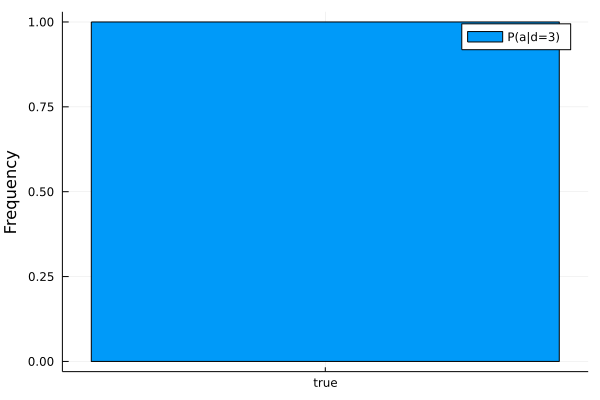

In [16]:
@gen function model2()
    a = @trace(bernoulli(0.5),:a)
    b = @trace(bernoulli(0.5),:b)
    c = @trace(bernoulli(0.5),:c)
    d = a+b+c
    if d == 3
        @trace(bernoulli(0.9999),:"d==3")
    else
        @trace(bernoulli(0.00001),:"d==3")    
    end
    d
end

ys=[]
for _ in 1:1000
    trace = importence_resamplin_inference(model2, "d==3",true, 100)
    push!(ys,trace[:a])
end
viz(ys,"P(a|d=3)")

The output of `importence_resamplin_inference` is a trace that describes appropriate beliefs about the likely value of `a`,`b`,`c` conditioned on `d` being equal to 3.

Now suppose that we condition on `d` being greater than or equal to 2. Then `a` need not be 1, but it is more likely than not to be. (Why?) The corresponding plot shows the appropriate distribution of beliefs for `A` conditioned on this new fact:

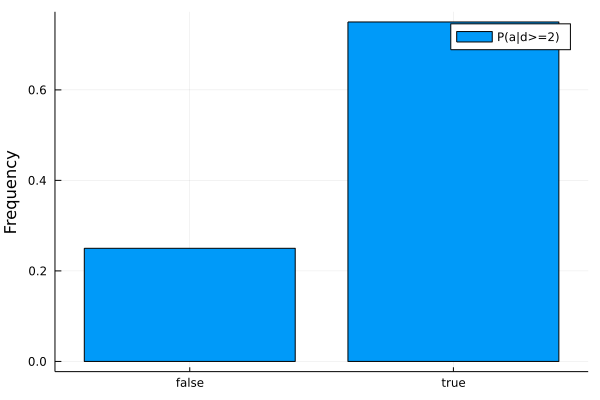

In [17]:
@gen function model3()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    if a+b+c >= 2
        @trace(bernoulli(0.999),:"d>=2")
    else
        @trace(bernoulli(0.001),:"d>=2")
    end
end
ys=[]
for _ in 1:100
    trace=importence_resamplin_inference(model3, "d>=2",true, 100)
    push!(ys,trace[:a])
end
viz(ys,"P(a|d>=2)")

Going beyond the basic intuition of “hypothetical reasoning”,  infernce in the presence of condition can be understood in several, equivalent, ways. We focus on two: the process of rejection sampling, and the the mathematical formulation of a conditional distribution

### Rejection Sampling
How can we imagine answering a hypothetical such as those above? We have already seen how to get a sample from a generative model, without constraint, by simply running the evaluation process “forward” (i.e. simulating the process). We can get conditional samples by forward sampling the entire model, but only keeping the sample if the value passed to condition is true. For instance, to sample from the above model “a given that d is greater than 2” we could:

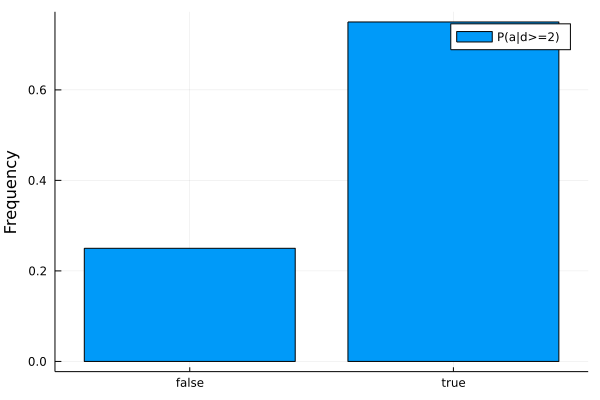

In [7]:
@gen function takeSample()
    a = @trace(bernoulli(0.5),:a)
    b = @trace(bernoulli(0.5),:b)
    c = @trace(bernoulli(0.5),:c)
    d = a+b+c
    d >=2 ? a : @trace(takeSample(), :t)
end
ys = [get_retval(simulate(takeSample,())) for _ in 1:100]
viz(ys,"P(a|d>=2)")

Notice that we have used a stochastic recursion to sample the model repeatedly until `d >= 2` is `true`, and we then return `a`: we generate and test until the condition is satisfied. This process is known as rejection sampling; we can use this technique to make a more general function that implements infernce using a predicat over the trace:

In [16]:
function  rejection_sampeling(model,args,pred)
    trace=simulate(model,args)
    while(!pred(trace))
        trace=simulate(model,args)
    end
    trace
end

rejection_sampeling (generic function with 1 method)

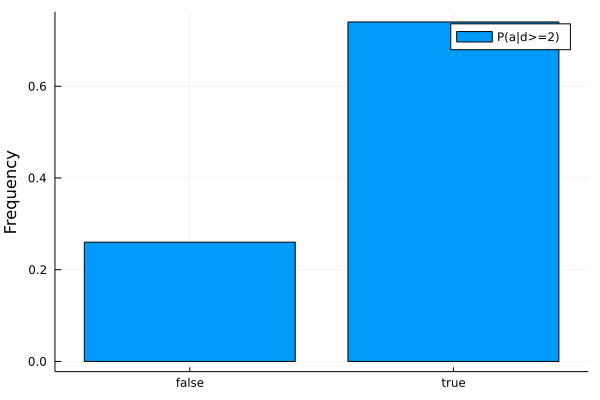

In [20]:
N=100
ys=[rejection_sampeling(model3,(),x -> x["d>=2"]) for _ in 1:N]

viz(map(x-> x[:a],ys),"P(a|d>=2)")

##Conditional Distributions
The formal definition of conditional probability in probability theory is:
$$P(A=a∣B=b)=\frac{P(A=a,B=b)}{P(B=b)}$$
Here $P(A=a∣B=b)$ is the probability that “event” A has value a given that B has value b. (The meaning of events A and B must be given elsewhere in this notation, unlike a Gen generative function, which contains the full model specification, conditioning is done in the inference function) The joint probability, $P(A=a,B=b)$, is the probability that A has value a and B has value b. So the conditional probability is simply the ratio of the joint probability to the probability of the condition.

In the case of a Gen infernce with a obseravtion, $A=a$ will be the “event” that $A = a$, while $B = b$ will be the event that the value passed to obseravtion is true (so b is True). Because each of these is a regular (unconditional) probability, they and their ratio can often be computed exactly using the rules of probability. we will implement infernce base on that (by first enumerating all the possible executions of the model):

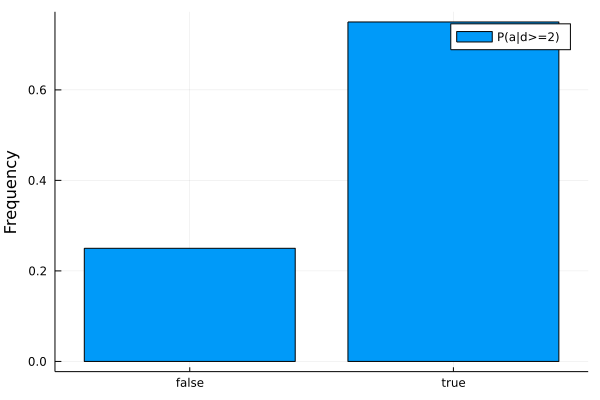

In [27]:
##inference by enumeration function for 3 i.i.d. bernoulli variables a,b,c
function enumeration_infernce(model,args,var)
    support=[true,false]
    results = [0.0,0.0]
    trace = simulate(model,args)
    for (a1,b1,c1) in Iterators.product(support,support,support)        
        constraints  = Gen.choicemap((:a, a1),(:b, b1),(:c, c1))        
        (trace, w) = generate(model, (), constraints)
        if a1+b1+c1 >= 2 
            results[a1+1] = results[a1+1] + w
        end
    end
    return Dict([false => results[1], true => results[2]])
end

ys=enumeration_infernce(model3,(),:a)
viz(ys,"P(a|d>=2)",true,sum(values(ys)))       
        

### Connection to rejection sampling
The above notion of conditional distribution in terms of rejection sampling is equivalent to the mathematical definition, when both are well-defined. (There are special cases when only one definition makes sense. For instance, when continuous random choices are used it is possible to find situations where rejection sampling almost never returns a sample but the conditional distribution is still well defined. Why?)

Indeed, we can use the process of rejection sampling to understand this alternative definition of the conditional probability $P(A=a∣B=b)$. Imagine that we have sampled $N_{total}$ times. We only keep those samples in which the condition is true, say there are $N_{B=True}$ of them. Of these some number $N_{A=a,B=True}$ have the returned value a. The ratio 
$$\frac{N_{A=a,B=True}}{N_{B=True}}=\frac{\frac{N_{A=a,B=True}}{N_{total}}}{\frac{N_{B=True}}{N_{total}}}$$
is the fraction of times that $$ when $B=True$. When the number of samples is very large this converges to $\frac{P(A=a,B=True)}{P(B=True)}$. Thus the rejection sampling definition of conditional probability implies the above (probability ratio) definition.

Try using the formula for conditional probability to compute the probability of the different return values in the above examples. Check that you get the same probability that you observe when using rejection sampling.

### Bayes Rule
One of the most famous rules of probability is Bayes’ rule, which states:

$$P(h∣d)=\frac{P(d∣h)P(h)}{P(d)}$$
It is first worth noting that this follows immediately from the definition of conditional probability:

$$P(h∣d)=\frac{P(d,h)}{P(d)}=\frac{P(d,h)P(h)}{P(d)P(h)}=\frac{P(d∣h)P(h)}{P(d)}$$
Next we can ask what this rule means in terms of sampling processes. Consider the program:

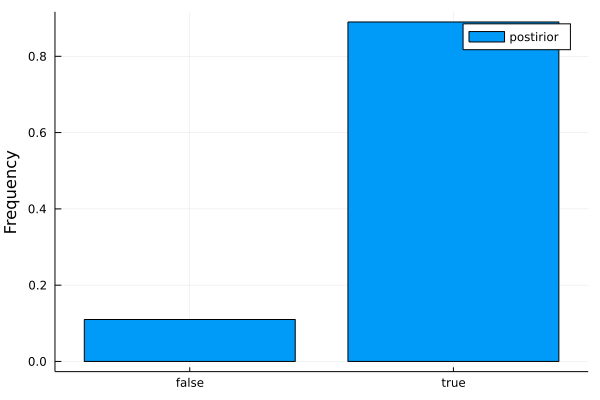

In [23]:

@gen function model4()
    hypothesis = @trace(bernoulli(0.5), :hypothesis) #prior  
    if hypothesis #adding noise
        data = @trace(bernoulli(0.9),:data) 
    else
        data = @trace(bernoulli(0.1),:data)
    end    
end

ys=[]
for _ in 1:100
    trace=importence_resamplin_inference(model4, :data,true, 100)
    push!(ys,trace[:hypothesis])
end
viz(ys,hcat("postirior"))

we have generated a value, the hypothesis, from some distribution called the prior, then added noise to get the observed data, the probability of such an observation function is usually called the likelihood. AfterwardsFinally we have returned the hypothesis, conditioned on the observation being equal to some observed data—this conditional distribution is called the posterior. This is a typical setup in which Bayes’ rule is used.

Bayes’ rule simply says that, in special situations where the model decomposes nicely into a part “before” the value to be returned (hypothesis) and a part “after” the value to be returned, then the conditional probability can be expressed simply in terms of the prior and likelihood components of the model. This is often a useful way to think about conditional inference in simple settings. However, we will see examples as we go along where Bayes’ rule doesn’t apply in a simple way, but the conditional distribution is equally well understood in other terms.

### Conditions and observations
A very common pattern is to condition directly on the value of a sample from some distribution. For instance here we try to recover a true number from a noisy observation of it:

In [26]:
@gen function model5()
    trueX = @trace(normal(0,1),:trueX)
    obsX = @trace(normal(trueX,0.1),:obsX)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##model5#272", Bool[], false)

In [203]:
sample=rejection_sampeling(model5,x -> x[:obsX]==0.2)


You will note that this never finishes. (Why? Think about what rejection sampling tries to do here….) In Gen we use choicemap,  to express the pattern of conditioning on a value sampled directly from a distribution. it is clearer. well look at the importance resampeling inference agian

In [91]:
function importence_resamplin_inference(model, vars,values, amount_of_computation)
    
    # Create a choice map that maps model addresses - var 
    # to observed value - value. We leave other variables
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    iterable= zip
    for (var,value) in zip(vars,values)        
        observations[var] = value
    end
           
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (), observations, amount_of_computation);
    return trace
end;

as we can see we fist get the the observables vars and their values and then we resample the model given these obesrvation

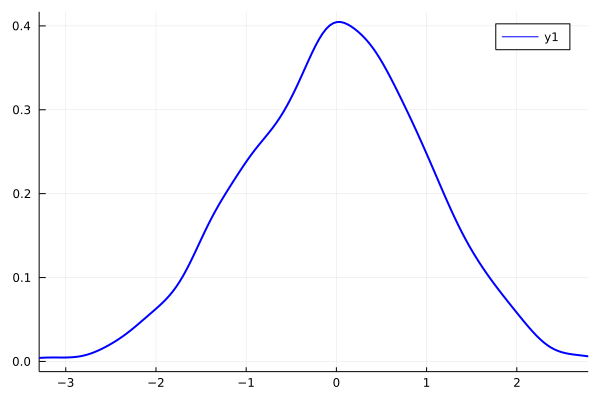

In [51]:
traces=[simulate(model5,()) for _ in 1:1000]
ret_values=map(x -> Gen.get_retval(x),traces)
plot(ret_values, seriestype = :density, xlim = (minimum(ret_values),maximum(ret_values)), legend = :best, w = 2, c = :blue)


It is natural and common to condition a generative model on a value for one of the variables declared in this model (i.e. to observe its value).one may wish to ask for more complex hypotheticals: “what if P,” where P is a complex proposition composed out of variables declared in the model. a relevent example is model3 where we express ?????

### Factors
Factor is like making a soft assumption that is merely preferred to be true. For instance, suppose we flip a single coin(sample a fair bernoulli rv). If we obsrve on the outcome being true, then the outcome must be true:

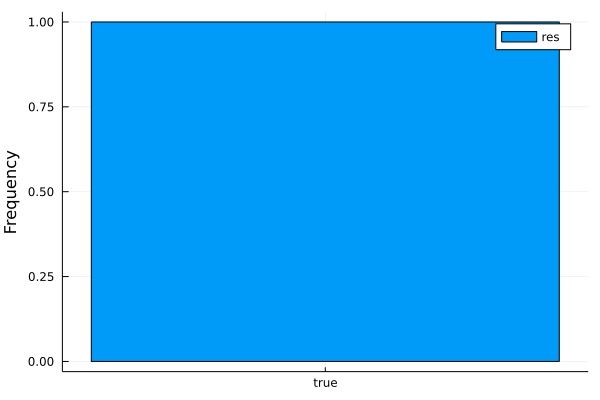

In [114]:
@gen function ber()
    @trace(bernoulli(0.5),:res)
end
obervation=choicemap((:res, true))
ys=[]
for _ in 1:100
    (trace, _) =generate(ber,(),obervation)
    push!(ys,get_retval(trace))
end
viz(ys,"res")

However, if we swap condition for factor, we simply make heads more likely:

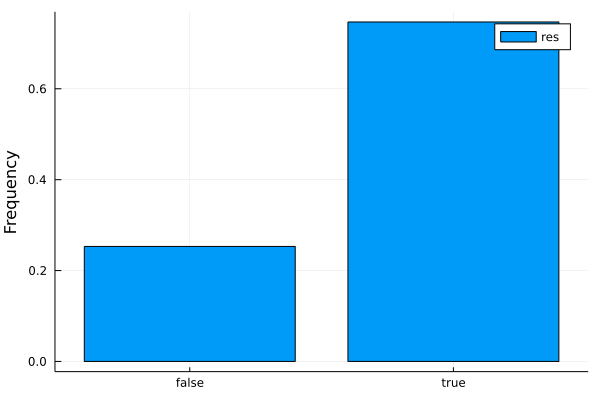

In [201]:
@gen function factor(x)
    @trace(bernoulli(exp(x)), :factor_x)
end
@gen function ber()
    res=@trace(bernoulli(0.5),:res)
    @trace(factor(res))
    res
end
ys=[]
for _ in 1:1000
    trace=importence_resamplin_inference(ber, [:factor_x],[true], 100)
    push!(ys,trace[:res])
end
viz(ys,"res")

Technically, `factor(x)` adds x to the unnormalized log-probability of the program execution within which it occurs. Thus, to get the new probabilities induced by the factor statement we compute the normalizing constant given these log-scores. The resulting probability $P(A=true)$ is:

$$P(A=true)=\frac{e^1}{e^0+e^1}$$
Play with this example. Can you revise the example to increase the probability of heads?

The factor construct is very general. Both condition and observe can be written easily in terms of factor. However models are often clearer when written with the more specialized forms. In machine learning it is common to talk of directed and undirected generative models; directed models can be thought of as those made from only sample and observe, while undirected models include factor (and often have only factors).

### Example: Reasoning about Tug of War
Imagine a game of tug of war, where each person may be strong or weak, and may be lazy or not on each match. If a person is lazy they only pull with half their strength. The team that pulls hardest will win. We assume that strength is a continuous property of an individual, and that on any match, each person has a 1 in 3 chance of being lazy. This Julia and Gen code runs a tournament between several teams, mixing up players across teams. Can you guess who is strong or weak, looking at the tournament results?

In [60]:
using Memoization
@gen function strength1(person)
  sampled_strength=@trace(normal(1,1), :sampled_strength)  
  @memoize func(y) = (println("Computed $x,$y"); (x,y))
end
 strength1(person) = @memoize strength1(person)
 @gen function lazy(person)
     @trace(bernoulli(1/3),:lazy)
 end
 @gen function pulling(pelazy = rson)
   @trace(lazy(person)) ? strength(person) / 2 : strength(person) 
 end
 
 println(strength("bob"))
 println(strength("bob"))
 pulling("bob")
# function totalPulling(team)
#   vec_pulling=Map(pulling)
#   sum(vec_pulling(team))
# end
# function winner(team1, team2)
#   totalPulling(team1) > totalPulling(team2) ? team1 : team2
# end
# print([
#     winner(["alice", "bob"], ["sue", "tom"]),
#     winner(["alice", "bob"], ["sue", "tom"]),
#     winner(["alice", "sue"], ["bob", "tom"]),
#     winner(["alice", "sue"], ["bob", "tom"]),
#     winner(["alice", "tom"], ["bob", "sue"]),
#     winner(["alice", "tom"], ["bob", "sue"])
#])

LoadError: LoadError: @memoize must be applied to a method definition
in expression starting at In[60]:6

SPACE FILLER

### Example: Causal Inference in Medical Diagnosis
This classic Bayesian inference task is a special case of conditioning. Kahneman and Tversky, and Gigerenzer and colleagues, have studied how people make simple judgments like the following:
> The probability of breast cancer is 1% for a woman at 40 who participates in a routine screening. If a woman has breast cancer, the probability is 80% that she will have a positive mammography. If a woman does not have breast cancer, the probability is 9.6% that she will also have a positive mammography. A woman in this age group had a positive mammography in a routine screening. What is the probability that she actually has breast cancer?

What is your intuition? Many people without training in statistical inference judge the probability to be rather high, typically between 0.7 and 0.9. The correct answer is much lower, less than 0.1, as we can see by running this Gen generatice function and inference function:

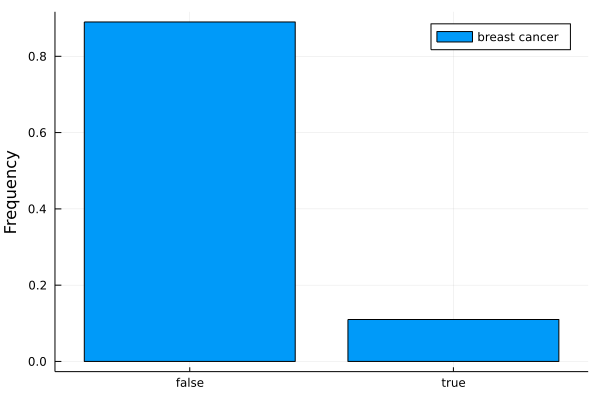

In [72]:
@gen function cancerDist()
    breastCancer = @trace(bernoulli(0.01), :breastCancer)
    breastCancer ? positiveMammogram=@trace(bernoulli(0.8), :positiveMammogram) : positiveMammogram=@trace(bernoulli(0.096), :positiveMammogram)
    return Dict(["breastCancer" => breastCancer])
end

function med_importence_resamplin_inference(model, value, amountOfSamples)
    observations = choicemap()
    observations[:positiveMammogram] = value

    (trace, _) = Gen.importance_resampling(model, (),observations, amountOfSamples);
    return trace
end

data =[ med_importence_resamplin_inference(cancerDist,true,500) for _ in 1:100]
viz(map(x-> x[:breastCancer],data),"breast cancer")

@Tversky1974 named this kind of judgment error *base rate neglect*, because in order to make the correct judgment, one must realize that the key contrast is between the *base rate* of the disease, 0.01 in this case, and the *false alarm rate* or probability of a positive mammogram given no breast cancer, 0.096.  The false alarm rate (or *FAR* for short) seems low compared to the probability of a positive mammogram given breast cancer (the *likelihood*), but what matters is that it is almost ten times higher than the base rate of the disease.  All three of these quantities are needed to compute the probability of having breast cancer given a positive mammogram using Bayes' rule for posterior conditional probability:

$$P(\text{cancer} \mid \text{positive mammogram}) = \frac{P(\text{positive mammogram} \mid \text{cancer} ) \times P(\text{cancer})}{P(\text{ positive mammogram})}$$
$$= \frac{0.8 \times 0.01}{0.8 \times 0.01 + 0.096 \times 0.99} = 0.078$$

@Gigerenzer1995 showed that this kind of judgment can be made much more intuitive to untrained reasoners if the relevant probabilities are presented as "natural frequencies", or the sizes of subsets of relevant possible outcomes:

> On average, ten out of every 1000 women at age 40 who come in for a routine screen have breast cancer.  Eight out of those ten women will get a positive mammography.  Of the 990 women without breast cancer, 95 will also get a positive mammography. We assembled a sample of 1000 women at age 40 who participated in a routine screening.  How many of those who got a positive mammography do you expect to actually have breast cancer?

Now one can practically read off the answer from the problem formulation: 8 out of 103 (95+8) women in this situation will have breast cancer.

Gigerenzer (along with Cosmides, Tooby and other colleagues) has argued that this formulation is easier because of evolutionary and computational considerations: human minds have evolved to count and compare natural frequencies of discrete events in the world, not to add, multiply and divide decimal probabilities.  But this argument alone cannot account for the very broad human capacity for causal reasoning.  We routinely make inferences for which we haven't stored up sufficient frequencies of events observed *in the world.* (And often for which no one has told us the relevant frequencies, although perhaps we have been told about degrees of causal strength or base rates in the form of probabilities or other linguistic encoding).

However, the basic idea that the mind is good at manipulating frequencies of situations, but bad at arithmetic on continuous probability values, can be extended to cope with novel situations if the frequencies that are manipulated can be frequencies of *imagined* situations. Recall that Church programs explicitly give instructions for sampling imagined situations, and only implicitly specify probability distributions. If human inference is similar to a Church query then it would readily create and manipulate imagined situations, and this could explain both why the frequency framing of Bayesian probability judgment is natural to people and how people cope with rarer and more novel situations.  The numbers given in the frequency formulation (or close approximations thereof) can be read off a tree of evaluation histories for 1000 calls of the Church program that specifies the causal model for this problem:

<center><img src="images/Cancer-world-tree.png" width="40%" height="40%" ></center>

Each path from root to leaf of this tree represents a sequence of random choices made in evaluating the above program (the first flip for breast-cancer, the second for positive-mammogram), with the number of traversals and the sampled value labeling each edge. (Because this is 1000 *random* samples, the number are close (but not exactly) those in the Gigerenzer, et al, story.) Selecting just the 106 hypothetical cases of women with a positive mammogram, and computing the fraction of those who also have breast cancer (7/106), corresponds exactly to `rejection-query`. Thus, we have used the causal representation in the above church program to manufacture frequencies which can be used to arrive at the inference that relatively few women with positive mammograms actually have breast cancer.

Yet unlike the rejection sampler people are quite bad at reasoning in this scenario. Why? One answer is that people don't represent their knowledge in quite the form of this simple church program.
Indeed, @Krynski2007 have argued that human statistical judgment is fundamentally based on conditioning more explicit causal models:  they suggested that "base rate neglect" and other judgment errors may occur when people are given statistical information that cannot be easily mapped to the parameters of the causal models they intuitively adopt to describe the situation.  In the above example, they suggested that the notion of a false alarm rate is not intuitive to many people---particularly when the false alarm rate is ten times higher than the base rate of the disease that the test is intended to diagnose!  They showed that "base rate neglect" could be eliminated by reformulating the breast cancer problem in terms of more intuitive causal models.  For example, consider their version of the breast cancer problem (the exact numbers and wording differed slightly):

> 1% of women at age 40 who participate in a routine screening will have breast cancer.  Of those with breast cancer, 80% will receive a positive mammogram.  20% of women at age 40 who participate in a routine screening will have a benign cyst.  Of those with a benign cyst, 50% will receive a positive mammogram due to unusually dense tissue of the cyst.  All others will receive a negative mammogram.  Suppose that a woman in this age group has a positive mammography in a routine screening. What is the probability that she actually has breast cancer?

This question is easy for people to answer---empirically, just as easy as the frequency-based formulation given above.  We may conjecture this is because the relevant frequencies can be computed from a simple query on the following more intuitive causal model:

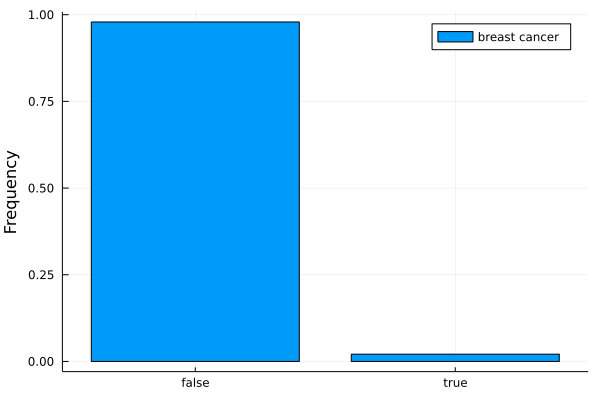

In [126]:
@gen function cancerDist2()
    breastCancer = @trace(bernoulli(0.01), :breastCancer)
    benignCyst = @trace(bernoulli(0.2), :benignCyst)
    q=1
    if breastCancer
        q = q * (1 - 0.2)
    end
    if benignCyst
        q = q * (1 - 0.5)
    end
    positiveMammogram=@trace(bernoulli(1 - q), :positiveMammogram)
    return Dict(["breastCancer" => breastCancer])
end

data =[ med_importence_resamplin_inference(cancerDist2,true,500) for _ in 1:1000]
viz(map(x-> x[:breastCancer],data),"breast cancer")


Because this causal model—this WebPPL program—is more intuitive to people, they can imagine the appropriate situations, despite having been given percentages rather than frequencies. What makes this causal model more intuitive than the one above with an explicitly specified false alarm rate? Essentially we have replaced probabilistic dependencies on the “non-occurrence” of events (e.g., the dependence of a positive mammogram on not having breast cancer) with dependencies on explicitly specified alternative causes for observed effects (e.g., the dependence of a positive mammogram on having a benign cyst).

A causal model framed in this way can scale up to significantly more complex situations. Recall our more elaborate medical diagnosis network from the previous section, which was also framed in this way using noisy-logical functions to describe the dependence of symptoms on disease:

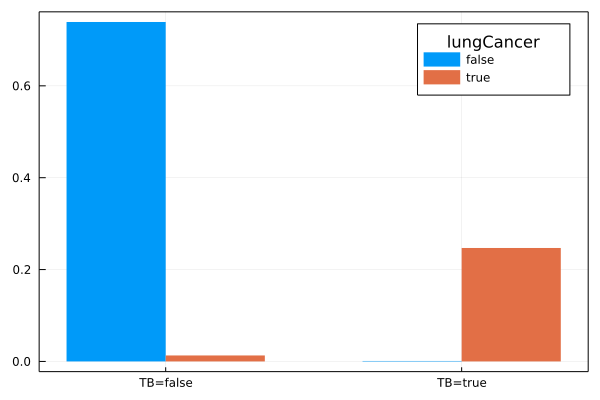

In [9]:
@gen function dieaseses()
    lungCancer = @trace(bernoulli(0.01), :lungCancer)
    TB = @trace(bernoulli(0.005), :TB)
    cold = @trace(bernoulli(0.2), :cold)
    stomachFlu = @trace(bernoulli(0.1), :stomachFlu)
    other = @trace(bernoulli(0.1), :other)

    q_cough = q_fever = q_chestPain = q_shortnessOfBreath = 1
    if cold 
        q_cough = q_cough * (1 - 0.5)
        q_fever = q_fever * (1 - 0.3)
    end
    if lungCancer
        q_cough = q_cough * (1 - 0.3)
        q_chestPain = q_chestPain * (1 - 0.4)
        q_shortnessOfBreath = q_shortnessOfBreath * (1 - 0.4)
    end
    if TB
        q_cough = q_cough * (1 -0.7)
        q_fever = q_fever * (1 - 0.2)
        q_chestPain = q_chestPain * (1 - 0.5)
        q_shortnessOfBreath = q_shortnessOfBreath * (1 - 0.5)
    end
    if stomachFlu
        q_fever = q_fever * (1 - 0.5)
    end
    if other
        q_cough = q_cough * (1 -0.01)
        q_fever = q_fever * (1 - 0.01)
        q_chestPain = q_chestPain * (1 - 0.01)
        q_shortnessOfBreath = q_shortnessOfBreath * (1 - 0.01)
    end
    @trace(bernoulli(1 - q_cough), :cough)
    @trace(bernoulli(1 - q_fever), :fever)
    @trace(bernoulli(1 - q_chestPain), :chestPain)
    @trace(bernoulli(1 - q_shortnessOfBreath), :shortnessOfBreath)
    return Dict(["lungCancer" => lungCancer,"TB" => TB])
end       

function inferDiseases(amountOfSamples)
    observations = choicemap()
    observations[:cough] = true
    observations[:fever] = true
    observations[:chestPain] = true
    observations[:shortnessOfBreath] = true

    (trace, _) = Gen.importance_resampling(dieaseses, (),observations, amountOfSamples);
    return trace

end

data = [inferDiseases(1000) for _ in 1:1000]
TB_true = map(x -> get_retval(x)["lungCancer"],filter(x ->get_retval(x)["TB"], data))
TB_false = map(x -> get_retval(x)["lungCancer"],filter(x ->!get_retval(x)["TB"], data))
groupedviz([TB_true,TB_false],["TB=false","TB=true","TB=false","TB=true"],[false,true],2,"","","","lungCancer",1000)

You can use this model to infer conditional probabilities for any subset of diseases conditioned on any pattern of symptoms. Try varying the symptoms in the conditioning set or the diseases in the inference, and see how the model’s inferences compare with your intuitions. For example, what happens to inferences about lung cancer and TB in the above model if you remove chest pain and shortness of breath as symptoms? (Why? Consider the alternative explanations.) More generally, we can condition on any set of events – any combination of symptoms and diseases – and query any others. We can also condition on the negation of an event (using the JavaScript negation operator !): how does the probability of lung cancer (versus TB) change if we observe that the patient does not have a fever (i.e. condition(!fever)), does not have a cough, or does not have either symptom?

As we discussed above, WebPPL program thus effectively encodes the answers to a very large number of possible questions in a very compact form. In the program above, there are 39=19683 possible simple conditions corresponding to conjunctions of events or their negations (because the program has 9 stochastic Boolean-valued functions, each of which can be observed true, observed false, or not observed). Then for each of those conditions there are a roughly comparable number of queries, corresponding to all the possible conjunctions of variables that can be in the return value expression. This makes the total number of simple questions encoded on the order of 100 million. We are beginning to see the sense in which probabilistic programming provides the foundations for constructing a language of thought, as described in the Introduction: a finite system of knowledge that compactly and efficiently supports an infinite number of inference and decision tasks.

Expressing our knowledge as a probabilistic program of this form also makes it easy to add in new relevant knowledge we may acquire, without altering or interfering with what we already know. For instance, suppose we decide to consider behavioral and demographic factors that might contribute causally to whether a patient has a given disease:

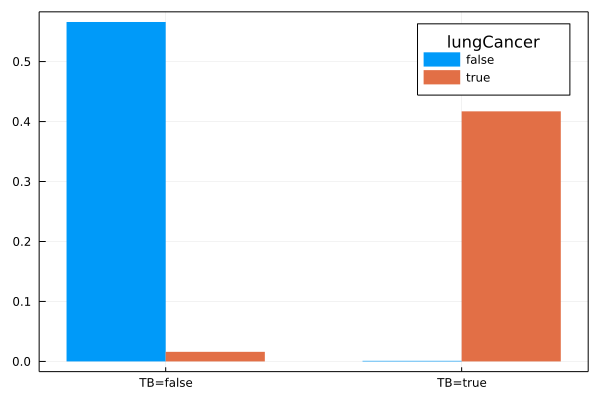

In [30]:
@gen function extendedDieasess() 
    worksInHospital = @trace(bernoulli(0.01),:worksInHospital)
    smokes = @trace(bernoulli(0.2),:smokes)
    if smokes
        lungCancer = @trace(brenoulli(0.02), :lungCancer)
    else
        lungCancer = @trace(brenoulli(0.01), :lungCancer)
    end
    if worksInHospital
        TB = @trace(brenoulli(0.01), :TB)
        cold = @trace(bernoulli(0.25), :cold)
    else
        TB = @trace(brenoulli(0.005), :TB)
        cold = @trace(bernoulli(0.2), :cold)
    end
    q_cough = q_fever = q_chestPain = q_shortnessOfBreath = 1
    if cold 
        q_cough = q_cough * (1 - 0.5)
        q_fever = q_fever * (1 - 0.3)
    end
    if lungCancer
        q_cough = q_cough * (1 - 0.3)
        q_chestPain = q_chestPain * (1 - 0.4)
        q_shortnessOfBreath = q_shortnessOfBreath * (1 - 0.4)
    end
    if TB
        q_cough = q_cough * (1 -0.7)
        q_fever = q_fever * (1 - 0.2)
        q_chestPain = q_chestPain * (1 - 0.5)
        q_shortnessOfBreath = q_shortnessOfBreath * (1 - 0.5)
    end
    if stomachFlu
        q_fever = q_fever * (1 - 0.5)
    end
    if other
        q_cough = q_cough * (1 -0.01)
        q_fever = q_fever * (1 - 0.01)
        q_chestPain = q_chestPain * (1 - 0.01)
        q_shortnessOfBreath = q_shortnessOfBreath * (1 - 0.01)
    end
    @trace(bernoulli(1 - q_cough), :cough)
    @trace(bernoulli(1 - q_fever), :fever)
    @trace(bernoulli(1 - q_chestPain), :chestPain)
    @trace(bernoulli(1 - q_shortnessOfBreath), :shortnessOfBreath)
    return Dict(["lungCancer" => lungCancer,"TB" => TB])   
end

function inferDiseases(amountOfSamples)
    observations = choicemap()
    observations[:cough] = true
    observations[:chestPain] = true
    observations[:shortnessOfBreath] = true

    (trace, _) = Gen.importance_resampling(dieaseses, (),observations, amountOfSamples);
    return trace

end
data = [inferDiseases(1000) for _ in 1:1000]
TB_true = map(x -> get_retval(x)["lungCancer"],filter(x ->get_retval(x)["TB"], data))
TB_false = map(x -> get_retval(x)["lungCancer"],filter(x ->!get_retval(x)["TB"], data))
groupedviz([TB_true,TB_false],["TB=false","TB=true","TB=false","TB=true"],[false,true],2,"","","","lungCancer",1000)

In [10]:
countmap([1,2,3,1,2,3,1,1])

Dict{Int64, Int64} with 3 entries:
  2 => 2
  3 => 2
  1 => 4